In [1]:
# 라이브러리 호출
import bok_da as bd
import numpy as np
import pandas as pd
import scipy.stats as sp
import matplotlib.pyplot as plt
import seaborn as sns

#### 본 사용자 매뉴얼에서는 var 모듈 중 분산분해에 대한 내용을 다룬다.
- 예측오차 분산분해(variance decomposition)
- 역사적 분해(historical decomposition)

## 1. 데이터 불러오기
- 작성자: 고려대학교 경제학과 강규호 교수, 디지털신기술팀 이창훈 과장

데이터는 한국의 전기대비 실질 GDP 성장률, CD91일 금리, 인플레이션율 소비자 가격 지수 (Consumer Price Index, CPI), CD91일 금리로 1999년 4분기부터 2023년 4분끼지의 분기별 자료이다. 해당 데이터는 ECOS (https://ecos.bok.or.kr/#/)에서 다운로드 받았으며 컴퓨터에 "python_data.xlsx"라는 이름의 엑셀파일의 "KORmacro"라는 시트에 저장되어 있다. 이때, 인플레이션율의 경우 소비자 가격 지수 (Consumer Price Index, CPI)의 전년동기대비 치분 (YoY)을 통해 미리 변환한 것이다.

`data` 폴더에서 `python_data.xlsx`를 불러온 후 파이썬 표준 자료형인 `pandas.DataFrame`으로 전처리를 수행한다. `DataFrame`은 테이블 형태의 데이터의 행(날짜)과 열(변수명) 정보를 가지고 있어, 행렬이나 벡터형태로 분석하는 것보다 유용하다. `df`라는 이름으로 할당하는 것이 일반적이다. 데이터프레임에 익숙하지 않은 경우 아래 셀의 코드를 줄별로 여러 셀로 나누어 실행해보는 것을 추천한다. 원천기관에서 raw 데이터를 불러오고 전처리하는 과정이 복잡해 보일 수 있지만, 한번 해두면 크게 코드를 수정할 필요없이 새로운 데이터에 대해서도 분석 가능한 형태로 전처리 할 수 있기 때문에 장기적으로 효율적인 방법이다.

In [2]:
df = pd.read_excel('data/python_data.xlsx', sheet_name='KORmacro') # 데이터 엑셀파일 불러오기
df = df.set_index('date') # date 명의 열을 인덱스로 지정한다.
df.index.name = None # 인덱스 이름 date를 제거한다.
df.index = df.index.str.replace('/', '-') # 2000/03 형식을 pandas가 날짜로 인식하도록 2000-3형식으로 변환한다.
df.index = pd.to_datetime(df.index) + pd.offsets.QuarterEnd(0) # 인덱스(행)를 날짜로 인식하도록 변환한다.
df.index.freq = pd.offsets.QuarterEnd() # 인덱스의 frequency를 분기말(2000-03-31)로 설정한다.
column_order = ['inf', 'rgdp', 'cd91'] # df의 열 순서를 리스트로 미리 할당
df = df[column_order] # df의 열 순서를 column_order에 맞게 변경
df1 = df.copy()
df1

,inf,rgdp,cd91
2000-12-31,2.508257,-0.3,6.97
2001-03-31,3.627876,1.2,5.95
2001-06-30,4.919778,1.3,5.78
2001-09-30,4.158456,1.4,4.97
2001-12-31,3.244327,1.8,4.58
...,...,...,...
2022-12-31,5.083054,-0.3,3.91
2023-03-31,4.496285,0.3,3.64
2023-06-30,3.212650,0.6,3.63
2023-09-30,3.079117,0.6,3.74


## 2. 예측오차 분산 분해 (Forecast Error Variance Decomposition)

`4-03 (시계열분석, VAR) 충격반응함수분석.ipynb`에서 설명한 VAR(p) 모형 추정을 통해 예측오차 분산분해 분석을 수행할 수 있다. VectorAutoRegression 클래스의 메서드인 `variance_decomposition()`를 사용한다. 자세한 내용은 매뉴얼 `4-03 (시계열분석, VAR) 충격반응함수분석.ipynb`과 본 매뉴얼 제일 아래 셀의 매뉴얼 `(참고 1)`를 참조.

### (예시: 단기 제약 하 VAR(2) 모형 추정과 분산분해)

In [13]:
from bok_da.ts.var import VectorAutoRegression as VAR
from bok_da.ts.var import order_var

p = order_var(df1, lag_max=4)
m_short = VAR(lag=p.bic)

아래 코드와 같이 `variance_decomposition` 메서드를 이용해 분산분해 분석을 수행한다. 결과는 array 자료형으로 `var_decomp`로 저장되며, `verbose=False`로 설정할 경우 그림을 출력하지 않는다. 메서드는 `data`, `irf`(식별 방법), `h`(충격반응함수 기간) 등을 인자로 받는다.

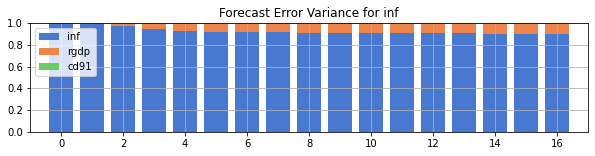

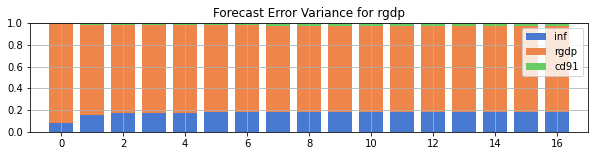

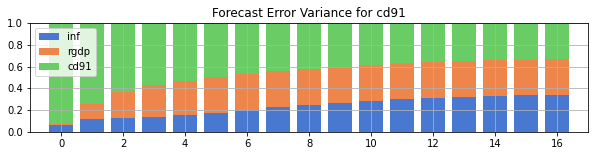

In [14]:
var_decomp = m_short.variance_decomposition(df1, verbose=True, figsize=(10,2)) # by default: irf='short, h=16

### (예시: 장기 제약 하 VAR(2) 모형 추정과 분산분해)

장기 제약인 경우에는 인자에 `irf='long'`을 입력해서 실행하면 된다.

In [15]:
m_long = VAR(lag=p.bic)

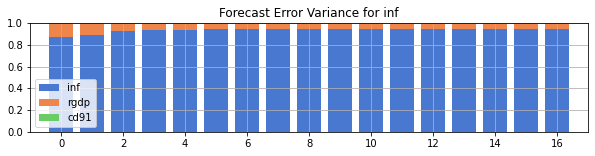

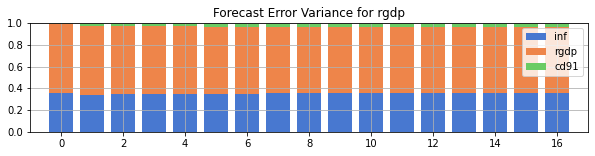

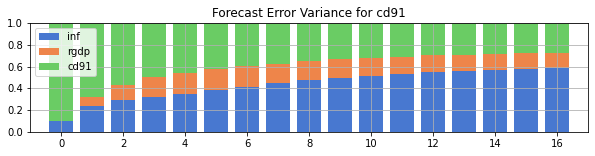

In [16]:
var_decomp = m_long.variance_decomposition(df1, irf='long', verbose=True, figsize=(10,2)) # by default: h=16

### (예시: Blanchard and Quah (1988)의 VAR 모형 추정과 분산분해)

In [11]:
df = pd.read_excel('data/python_data.xlsx', sheet_name='BQdata')
df = df.set_index('date')
df.index.name = None
df.index = pd.to_datetime(df.index) + pd.offsets.QuarterEnd(0)
df.index.freq = pd.offsets.QuarterEnd()
df.columns = ['gdp', 'unemp']
df2 = df.copy()
df2

,gdp,unemp
1948-06-30,0.854440,-0.142441
1948-09-30,0.012101,-0.066165
1948-12-31,-0.085058,-0.023222
1949-03-31,-2.076586,0.786387
1949-06-30,-1.491868,1.962663
...,...,...
1986-12-31,-0.055611,-0.629303
1987-03-31,0.641805,-0.886361
1987-06-30,0.403708,-1.243419
1987-09-30,0.380276,-1.533809


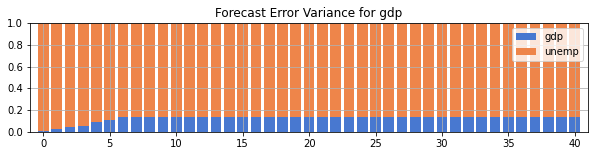

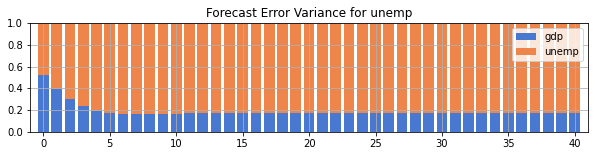

In [17]:
m_bq = VAR(lag=8)
var_decomp = m_bq.variance_decomposition(df2, irf='long', h=40, verbose=True, figsize=(10,2))

## 3. 역사적 분해 (Historical Decomposition)

VAR(p) 모형 추정을 통한 분산분해 분석 외 VectorAutoRegression 클래스 인스턴스의 `historical_decomposition()` 메서드를 이용해 역사적 분해 분석을 수행할 수 있다. 자세한 내용은 매뉴얼 `4-03 (시계열분석, VAR) 충격반응함수분석.ipynb`과 본 매뉴얼 제일 아래 셀의 매뉴얼 `(참고 2)`를 참조.

`historical_decomposition` 메서드 결과는 hist_decomp로 저장되며 자료형은 numpy.array이다. verbose=False로 설정할 경우 그림을 출력하지 않는다.  메서드는 `data`, `irf`(식별 방법) 등을 인자로 받는다.

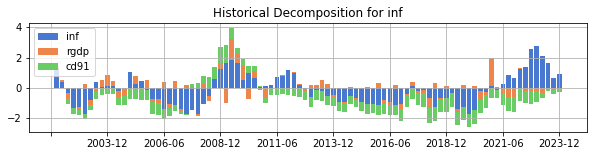

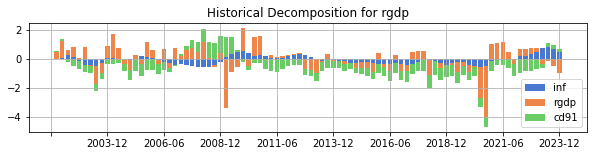

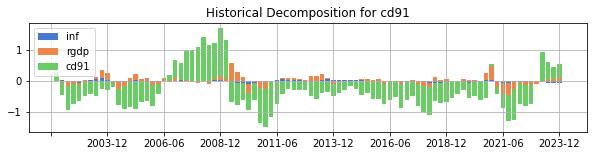

In [20]:
hist_decomp = m_short.historical_decomposition(df1, verbose=True, figsize=(10,2)) # by default: irf='short'

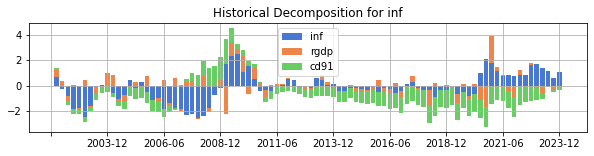

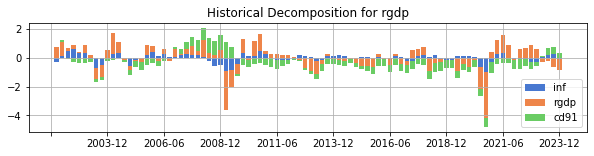

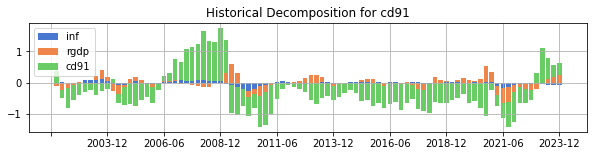

In [21]:
hist_decomp = m_long.historical_decomposition(df1, irf='long', verbose=True, figsize=(10,2))

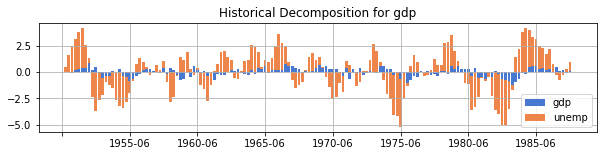

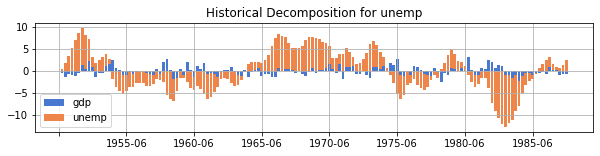

In [22]:
hist_decomp = m_bq.historical_decomposition(df2, irf='long', verbose=True, figsize=(10,2))

### (참고 1) 예측오차 분산분해
예측오차 분산 분해 (Forecast Error Variance Decomposition)의 목적은 VAR 시스템을 구성하는 각 변수의 예측오차에 특정 구조충격이 얼마만큼 기여하는지 보는 것이다. 다음과 같이 잘 식별되고 선형 과정으로 표현 가능한 구조형 VAR 모형이 있다가 하자.
\begin{align}
    y_{t} & = B_{0}^{-1}B_{1}y_{t-1} + \cdots + B_{0}^{-1}B_{p}y_{t-p}+B_{0}^{-1}e_{t} \notag \\
    & = \theta_{0}e_{t} + \theta_{1}e_{t-1} + \theta_{2}e_{t-2} + \cdots \notag \\
    & = \sum_{j=0}^{\infty}{\theta_{j}e_{t-j}}\text{, }e_{t}\sim\mathcal{N}(0,I_{k}) \notag
\end{align}
이때, 정보집합 $I_{t}$가 주어질 경우 $t$기에 하는 $h$기 이후 최적 예측은
\begin{align}
    & y_{t+h} = \underbrace{\theta_{0}e_{t+h} + \theta_{1}e_{t+h-1}+\cdots+\theta_{h-1}e_{t+1}}_{\text{정보집합에 포함되지 않은 부분}}+\underbrace{\theta_{h}e_{t}+\theta_{h+1}e_{t-1}+\cdots}_{\text{정보집합에 포함된 부분}} \notag \\
    & \Rightarrow \mathbb{E}(y_{t+h}|I_{t}) = \theta_{h}e_{t} + \theta_{h+1}e_{t-1} + \theta_{h+2}e_{t-2}+\cdots \notag
\end{align}
와 같다. 이를 사용하여 예측오차를 구한다면 다음과 같다.
\begin{align}
    \varepsilon_{t,h} & = y_{t+h} - \mathbb{E}(y_{t+h}|I_{t}) \notag \\
    & = \theta_{0}e_{t+h} + \cdots+\theta_{h-1}e_{t+1}+\theta_{h}e_{t}+\theta_{h+1}e_{t-1}+\cdots \notag \\
    & \hspace{5ex} - (\theta_{h}e_{t}+\theta_{h+1}e_{t-1}+\cdots) \notag \\
    & = \theta_{0}e_{t+h} + \theta_{1}e_{t+h-1} + \cdots + \theta_{h-1}e_{t+1} \notag \\
    & = \sum_{i=0}^{h-1}{\theta_{i}e_{t+h-i}} \notag
\end{align}
더 나아가, 위에서 구한 예측오차의 분산은 다음과 같이 도출할 수 있다.
\begin{align}
    Var(\varepsilon_{t,h}) & = Var(\theta_{0}e_{t+h}+\cdots+\theta_{h-1}e_{t+1}) \notag \\
    & = \mathbb{E}[(\theta_{0}e_{t+h}+\cdots+\theta_{h-1}e_{t+1})(\theta_{0}e_{t+h}+\cdots+\theta_{h-1}e_{t+1})^{\prime}] \notag \\
    & = \mathbb{E}[\theta_{0}e_{t+h}e_{t+h}^{\prime}\theta_{0}^{\prime}+\cdots+\theta_{h-1}e_{t+1}e_{t+1}^{\prime}\theta_{h-1}^{\prime}] \notag \\
    & = \underbrace{\theta_{0}\theta_{0}^{\prime}}_{(k\times k)}+\cdots+\underbrace{\theta_{h-1}\theta_{h-1}^{\prime}}_{(k\times k)}\cdots\text{ since }\mathbb{E}(e_{t}e_{t}^{\prime})=I_{k} \notag \\
    & = \sum_{i=0}^{h-1}{\theta_{i}\theta_{i}^{\prime}} \notag
\end{align}
우리의 목적은 예측오차의 분산이기 때문에 $\theta_{i}\theta_{i}^{\prime}$의 대각 원소에만 집중하면, 위 표현은 다음과 같이 표현할 수 있다.
\begin{align}
    & Var(\varepsilon_{t,h}) \notag \\
    & = \theta_{1}\theta_{1}^{\prime} + \cdots + \theta_{h-1}\theta_{h-1}^{\prime} \notag \\
    & = \begin{pmatrix}
        \theta_{11}^{1} & \theta_{12}^{1} & \cdots & \theta_{1K-1}^{1} & \theta_{1K}^{1} \\
        \theta_{21}^{1} & \theta_{22}^{1} & \cdots & \theta_{2K-1}^{1} & \theta_{2K}^{1} \\ 
        \vdots & \vdots & \ddots & \vdots & \vdots
    \end{pmatrix}\begin{pmatrix}
        \theta_{11}^{1} & \theta_{21}^{1} & \cdots & \theta_{K-11}^{1} & \theta_{K1}^{1} \\
        \theta_{12}^{1} & \theta_{22}^{1} & \cdots & \theta_{K-12}^{1} & \theta_{K2}^{1} \\ 
        \vdots & \vdots & \ddots & \vdots & \vdots
    \end{pmatrix} + \cdots + \theta_{h-1}\theta_{h-1}^{\prime} \notag \\
    & = \begin{pmatrix}
        (\theta_{11}^{1})^{2}+\cdots+(\theta_{1K}^{1})^{2} & \cdot & \cdots \\
        \cdot & (\theta_{21}^{1})^{2}+\cdots+(\theta_{2K}^{1})^{2} & \cdots \\
        \vdots & \vdots & \ddots
    \end{pmatrix} + \cdots \notag \\
    & \hspace{5ex} + \begin{pmatrix}
        (\theta_{11}^{h-1})^{2}+\cdots+(\theta_{1K}^{h-1})^{2} & \cdot & \cdots \\
        \cdot & (\theta_{21}^{h-1})^{2}+\cdots+(\theta_{2K}^{h-1})^{2} & \cdots \\
        \vdots & \vdots & \ddots
    \end{pmatrix} \notag
\end{align}
따라서 $Var(\varepsilon_{t,h})$의 첫번째 원소는
\begin{equation}
    ((\theta_{11}^{1})^{2}+\cdots+(\theta_{1K}^{1})^{2}) + ((\theta_{11}^{2})^{2}+\cdots+(\theta_{1K}^{2})^{2}) + \cdots + ((\theta_{11}^{h-1})^{2}+\cdots+(\theta_{1K}^{h-1})^{2}) \notag
\end{equation}
와 같이 표현될 수 있다.

만약 $\theta_{jk,i}$를 $\theta_{i}$의 $(j,k)$ 번째 원소라고 한다면, $Var(\varepsilon_{t,h})$의 (j,j) 번째 원소는 $FV_{j}(h)$라고 표현할 수 있으며 우리가 목적으로 하고 있는 $y_{t+h}$의 j 번째 원소에 대한 예측오차의 분산이다. 따라서, $FV_{j}^{(k)}(h) = \sum_{i=0}^{h-1}{\theta_{jk,i}^{2}}$라고 할 때,
\begin{align}
    FV_{j}(h) & = \sum_{k=1}^{K}{\theta_{jk,0}^{2}} + \sum_{k=1}^{K}{\theta_{jk,1}^{2}}+\cdots+\sum_{k=1}^{K}{\theta_{jk,h-1}^{2}} \notag \\
    & = \sum_{i=0}^{h-1}{\sum_{k=1}^{K}{\theta_{jk,i}^{2}}} \notag \\
    & = \Bigg(\sum_{i=0}^{h-1}{\theta_{j1,i}^{2}}\Bigg) + \Bigg(\sum_{i=0}^{h-1}{\theta_{j2,i}^{2}}\Bigg) + \cdots + \Bigg(\sum_{i=0}^{h-1}{\theta_{jK,i}^{2}}\Bigg) \notag \\
    & = FV_{j}^{(1)}(h) + FV_{j}^{(2)}(h) + \cdots + FV_{j}^{(K)}(h) \notag
\end{align}
은 $y_{t+h}$의 j 번째 원소에 대한 전체 예측오차에 대한 k 번째 구조충격의 기여도를 의미한다. 그 결과, 각 예측시차 $h=0,\cdots,H$에 대해
\begin{align}
    & FV_{j}(h) = FV_{j}^{(1)}(h) + \cdots + FV_{j}^{(K)}(h) \notag \\
    & \Rightarrow 1 = \frac{FV_{j}^{(1)}(h)}{FV_{j}(h)} + \cdots + \frac{FV_{j}^{(K)}(h)}{FV_{j}(h)} \notag
\end{align}
를 도출할 수 있으며, 이는 각 예측시차 $h$에 대한 예측오차 분산 분해 결과라고 한다.

### (참고 2) 역사적 분해
예측오차 분산 분해와 유사하지만 살짝 다른 것이 변수의 역사적 분해 (historical decomposition)이다. 이때, 역사적 분해의 목적은 $y_{t}$라는 확률 과정을 생성하는데 있어서 과거 구조 충격들의 기여도를 보는 것이다.

구조형 VAR 모형이 다음과 같이 무한기 MA 과정으로 표현된다고 해보자.
\begin{align}
    y_{t} & = \theta_{0}e_{t} + \theta_{1}e_{t-1} + \theta_{2}e_{t-2} + \cdots + \theta_{t-p-1}e_{p+1} + \theta_{t-p}e_{p} + \cdots \notag \\
    & = \underbrace{\sum_{j=0}^{t-p-1}{\theta_{j}e_{t-j}}}_{(i)} + \underbrace{\sum_{j=t-p}^{\infty}{\theta_{j}e_{t-j}}}_{(ii)} \notag
\end{align}
이때, (i) 부분은 $y_{t}$에 대한 구성가능한 과거 충격이고 (ii) 부분은 $|\theta_{j}|<1$라는 가정이 성립되기 때문에 생략 가능한 먼 과거의 충격들의 영향이다. 따라서, 역사적 분해를 위해 고려하는 확률과정은 다음과 같이 표현될 수 있다.
\begin{equation}
    \hat{y}_{t} = \theta_{0}e_{t} + \theta_{1}e_{t-1} + \cdots + \theta_{t-p-1}e_{p+1} \notag
\end{equation}
해당 확률 과정을 사용하여, 다음과 같은 절차에 따라 파라미터 값과 잔차를 추정할 수 있다.

- <1 단계>: 축약형 VAR 모형 추정

    축약형 VAR 모형을 추정하고 다음과 같은 축약형 파라미터를 추정한다.
    $\begin{equation}
        \hat{A}_{1}\text{, }\cdots\text{, }\hat{A}_{p}\text{, }\hat{\Sigma} \notag
    \end{equation}$

- <2 단계>: 구조형 VAR 모형 식별

    단기, 또는 장기 제약과 같이 특정 형태의 식별 방법을 사용하여 구조형 VAR 모형을 식별하고 다음과 같은 구조형 파라미터를 추정할 수 있다.
    $\begin{equation}
        \hat{B}_{0}\text{, }\hat{B}_{1}\text{, }\cdots\text{, }\hat{B}_{p}\text{, }\Omega=I_{K} \notag
    \end{equation}$

- <3 단계>: 충격반응함수 도출

    구조형 VAR 모형을 사용하여 다음과 같이 충격반응함수를 도출한다.
    $\begin{equation}
        \theta_{0}\text{, }\theta_{1}\text{, }\cdots\text{, }\theta_{t-p-1} \notag
    \end{equation}$

- <4 단계>: 구조형 잔차를 도출

    축약형 잔차가
    $\begin{equation}
        \hat{u}_{t} = y_{t} = \hat{A}_{1}y_{t-1} - \cdots - \hat{A}_{p}y_{t-p} \notag
    \end{equation}$
    으로 표현될 때, $B_{0}^{-1}e_{t}=u_{t}$라는 관계를 사용하여 다음과 같이 구조형 잔차를 도출할 수 있다.
    $\begin{equation}
        \hat{e}_{t} = B_{0}\hat{u}_{t} \notag
    \end{equation}$

결과적으로 충격반응함수 $(\theta_{0},\theta_{1},\cdots,\theta_{t-p-1})$와 구조형 충격 $(\hat{e}_{t},\hat{e}_{t-1},\cdots,\hat{e}_{p+1})$을 도출했기 때문에 다음과 같이 $\hat{y}_{t}$라는 확률 과정의 역사를 알 수 있다.
\begin{equation}
    \hat{y}_{t} = \theta_{0}\hat{e}_{t} + \theta_{1}\hat{e}_{t-1}+\cdots+\theta_{t-p-1}\hat{e}_{p+1} \notag
\end{equation}
구체적으로 $y_{t}$가 $K$개의 반응변수로 구성된다고 하면 $\hat{y}_{t}$와 $\theta_{j}$는 다음과 같이 표현할 수 있다.
\begin{equation}
    \hat{y}_{t}=\begin{pmatrix}
        \hat{y}_{1t} \\
        \vdots \\
        \hat{y}_{it} \\
        \vdots \\
        \hat{y}_{Kt}
    \end{pmatrix}\text{ and }\theta_{j} = \begin{pmatrix}
        \theta_{11,j} & \cdots & \theta_{1k,j} & \cdots & \theta_{1K,j} \\
        \vdots & \ddots & \vdots & & \vdots \\
        \theta_{i1,j} & \cdots & \theta_{ik,j} & \cdots & \theta_{iK,j} \\
        \vdots & & \vdots & \ddots & \vdots \\
        \theta_{K1,j} & \cdots & \theta_{Kk,j} & \cdots & \theta_{KK,j}
    \end{pmatrix} \notag
\end{equation}
따라서, 각 $\hat{y}_{it}$는 다음과 같이 표현될 수 있다.
\begin{align}
    \hat{y}_{it} & = \theta_{i\cdot,0}\cdot\hat{e}_{t} + \cdots + \theta_{i\cdot,t-p-1}\cdot\hat{e}_{p+1} \notag \\
    & = \begin{pmatrix}
        \theta_{i1,0}\cdot\hat{e}_{1t} \\
        + \\
        \vdots \\
        + \\
        \theta_{iK,0}\cdot\hat{e}_{Kt}
    \end{pmatrix} + \begin{pmatrix}
        \theta_{i1,1}\cdot\hat{e}_{1t-1} \\
        + \\
        \vdots \\
        + \\
        \theta_{iK,1}\cdot\hat{e}_{Kt-1}
    \end{pmatrix} + \cdots + \begin{pmatrix}
        \theta_{i1,t-p-1}\cdot\hat{e}_{1p+1} \\
        + \\
        \vdots \\
        + \\
        \theta_{iK,t-p-1}\cdot\hat{e}_{Kp+1}
    \end{pmatrix} \notag
\end{align}

결과적으로 $\hat{y}_{it}$를 구성하는 과거 역사의 합에서 $\hat{y}_{it}^{(1)}$로 정의한 첫 번째 원소들의 합은 첫 번째 구조형 충격이 $\hat{y}_{t}$라는 확률 과정에 기여하는 것이다. 이를 수식으로 표현하면 다음과 같다.
\begin{equation}
    \hat{y}_{it}^{(1)} = \theta_{i1,1}\cdot\hat{e}_{1t} + \theta_{i1,1}\cdot\hat{e}_{1t-1} + \cdots + \theta_{i1,t-p-1}\cdot\hat{e}_{1p+1} \notag
\end{equation}
그러면
\begin{equation}
    \hat{y}_{it}^{(1)},\cdots,\hat{y}_{it}^{(K)} \notag
\end{equation}
을 도출하는 것은 $\hat{y}_{t}$를 구성하는 $i$ 번째 변수의 역사적 분해를 도출한 것과 동치가 된다.